In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

def plot_watermark_roc_and_tpr(watermarked_df: pd.DataFrame, unwatermarked_df: pd.DataFrame):
    # Extract the watermark scores from both DataFrames
    watermarked_scores = watermarked_df['zscore']
    unwatermarked_scores = unwatermarked_df['watermark_score']
    unwatermarked_scores = unwatermarked_scores[:len(watermarked_scores)]
    
    # Combine the scores
    all_scores = np.concatenate([watermarked_scores, unwatermarked_scores])

    # Create labels: 1 for watermarked, 0 for unwatermarked
    labels = np.concatenate([np.ones(len(watermarked_scores)), np.zeros(len(unwatermarked_scores))])

    # Compute the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(labels, all_scores)
    auc_score = roc_auc_score(labels, all_scores)
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Watermark Detection')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Print the AUC score
    print(f"AUC Score: {auc_score:.2f}")
    
    # Define the target FPR values
    target_fprs = [0.1, 0.01, 0.001]

    # Initialize dictionary to store TPRs at specific FPR values
    tpr_at_fprs = {}

    # Iterate over the target FPR values and find the closest FPR in the roc_curve result
    for target_fpr in target_fprs:
        # Find the index where FPR is closest to the target FPR
        idx = np.argmin(np.abs(fpr - target_fpr))
        tpr_at_fprs[target_fpr] = tpr[idx]
        print(f"TPR at FPR = {target_fpr}: {tpr[idx]:.4f}")

    return tpr_at_fprs

def plot_watermark_roc_and_tpr_z(watermarked_scores, unwatermarked_df: pd.DataFrame):
    unwatermarked_scores = unwatermarked_df['watermark_score']
    
    # Combine the scores
    all_scores = np.concatenate([watermarked_scores, unwatermarked_scores])

    # Create labels: 1 for watermarked, 0 for unwatermarked
    labels = np.concatenate([np.ones(len(watermarked_scores)), np.zeros(len(unwatermarked_scores))])

    # Compute the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(labels, all_scores)
    auc_score = roc_auc_score(labels, all_scores)
    
    # Plot the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Watermark Detection')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    # Print the AUC score
    print(f"AUC Score: {auc_score:.2f}")
    
    # Define the target FPR values
    target_fprs = [0.1, 0.01, 0.001]

    # Initialize dictionary to store TPRs at specific FPR values
    tpr_at_fprs = {}

    # Iterate over the target FPR values and find the closest FPR in the roc_curve result
    for target_fpr in target_fprs:
        # Find the index where FPR is closest to the target FPR
        idx = np.argmin(np.abs(fpr - target_fpr))
        tpr_at_fprs[target_fpr] = tpr[idx]
        print(f"TPR at FPR = {target_fpr}: {tpr[idx]:.4f}")

    return tpr_at_fprs

def breakup_attacks(df):
    # Break the DF up into smaller DFs
    dfs = []
    current_df = None

    # Iterate over the rows and split on step_num resets
    for i, row in df.iterrows():
        # Check if the step_num resets to -1, indicating a new sequence
        if row['mutation_num'] == -1:
            if current_df is not None and not current_df.empty:
                dfs.append(current_df.reset_index(drop=True))  # Save the current increasing DF
            current_df = pd.DataFrame([row])  # Start a new DataFrame with the reset row
        else:
            # Append the row to the current DataFrame
            current_df = pd.concat([current_df, pd.DataFrame([row])])

    # Add the last DataFrame if it exists and is non-empty
    if current_df is not None and not current_df.empty:
        dfs.append(current_df.reset_index(drop=True))
    
    return dfs

def extract_last_mutated_text(df: pd.DataFrame) -> str:
    # Filter the rows where quality_preserved is True
    filtered_df = df[df['quality_preserved'] == True]
    
    # Check if any row exists
    if not filtered_df.empty:
        # Extract the mutated_text from the last valid row
        return filtered_df.iloc[-1]['mutated_text']
    else:
        return None  # Return None if no row matches

def extract_zscore(df: pd.DataFrame) -> str:    
    # Check if any row exists
    if not df.empty:
        # Extract the mutated_text from the last valid row
        return df.iloc[-1]['watermark_score']
    else:
        return None  # Return None if no row matches
    
import pandas as pd

def process_dataframes(df_path: str, unwatermarked_df: pd.DataFrame):
    # Read the CSV file
    semstamp_sentence_df = pd.read_csv(df_path)

    # Break up attacks
    semstamp_sentence_df = breakup_attacks(semstamp_sentence_df)

    # Filter dataframes with at least 5 rows and more than 10 rows where 'quality_preserved' is True
    semstamp_sentence_df = [df for df in semstamp_sentence_df if len(df) >= 5]
    semstamp_sentence_df = [df for df in semstamp_sentence_df if df[df['quality_preserved'] == True].shape[0] > 10]

    # Extract relevant information
    semstamp_sentence_og_texts = [df.iloc[1]['current_text'] for df in semstamp_sentence_df]
    semstamp_sentence_prompts = [df.iloc[-1]['prompt'] for df in semstamp_sentence_df]
    semstamp_sentence_mutated_texts = [extract_last_mutated_text(df) for df in semstamp_sentence_df]
    semstamp_sentence_zscores = [extract_zscore(df) for df in semstamp_sentence_df]

    # Plot the ROC and TPR vs Z-scores
    plot_watermark_roc_and_tpr_z(semstamp_sentence_zscores, unwatermarked_df)

    # Return relevant information if needed
    return semstamp_sentence_og_texts, semstamp_sentence_prompts, semstamp_sentence_mutated_texts, semstamp_sentence_zscores

In [2]:
semstamp_unwatermarked_df = pd.read_csv('/data2/borito1907/impossibility-watermark/unwatermarked_scores/semstamp_detect_unwatermarked.csv')

semstamp_unwatermarked_mean_watermark = semstamp_unwatermarked_df['watermark_score'].mean()
semstamp_unwatermarked_std_watermark = semstamp_unwatermarked_df['watermark_score'].std()

print(f"Mean of watermark_score: {semstamp_unwatermarked_mean_watermark}")
print(f"Standard deviation of watermark_score: {semstamp_unwatermarked_std_watermark}")


Mean of watermark_score: -0.7281950363003581
Standard deviation of watermark_score: 0.933524266518816


In [3]:
adaptive_unwatermarked_df = pd.read_csv('/data2/borito1907/impossibility-watermark/unwatermarked_scores/adaptive_detect_unwatermarked.csv')

adaptive_unwatermarked_mean_watermark = adaptive_unwatermarked_df['watermark_score'].mean()
adaptive_unwatermarked_std_watermark = adaptive_unwatermarked_df['watermark_score'].std()

print(f"Mean of watermark_score: {adaptive_unwatermarked_mean_watermark}")
print(f"Standard deviation of watermark_score: {adaptive_unwatermarked_std_watermark}")


Mean of watermark_score: 51.60824692338929
Standard deviation of watermark_score: 5.957990385248221


In [4]:
semstamp_watermarked_df = pd.read_csv('/data2/borito1907/impossibility-watermark/data/WQE_semstamp/dev.csv')

In [5]:
adaptive_watermarked_df = pd.read_csv('/data2/borito1907/impossibility-watermark/data/WQE_adaptive/dev.csv')

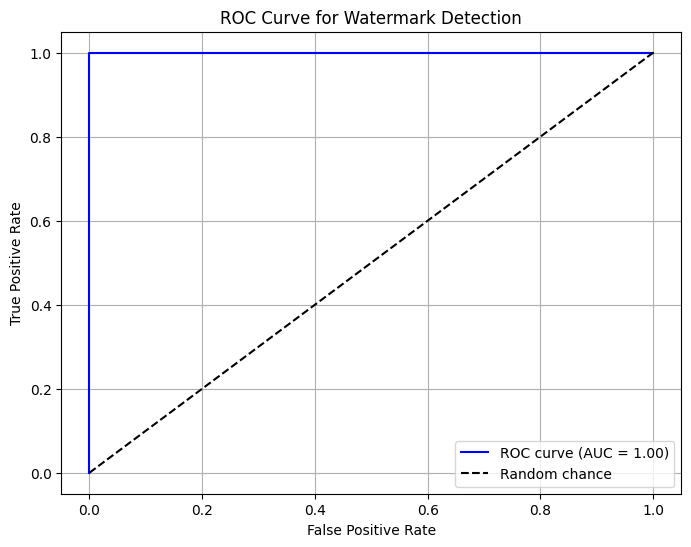

AUC Score: 1.00
TPR at FPR = 0.1: 1.0000
TPR at FPR = 0.01: 1.0000
TPR at FPR = 0.001: 0.0000


{0.1: 1.0, 0.01: 1.0, 0.001: 0.0}

In [6]:
plot_watermark_roc_and_tpr(semstamp_watermarked_df, semstamp_unwatermarked_df)

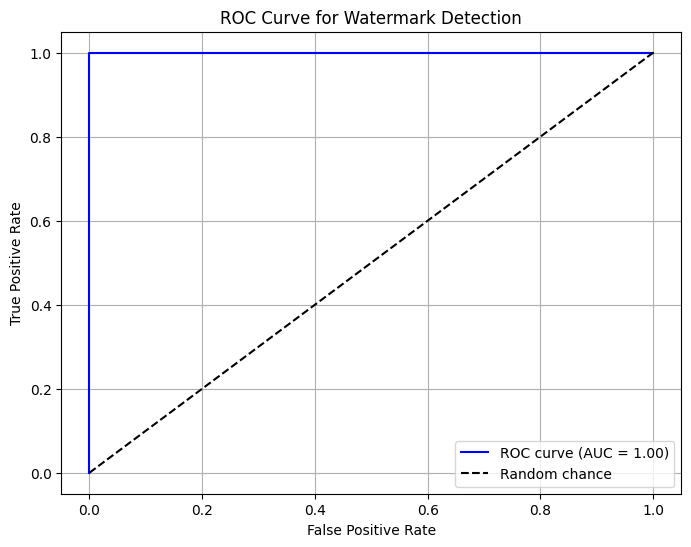

AUC Score: 1.00
TPR at FPR = 0.1: 0.0000
TPR at FPR = 0.01: 0.0000
TPR at FPR = 0.001: 0.0000


{0.1: 0.0, 0.01: 0.0, 0.001: 0.0}

In [7]:
plot_watermark_roc_and_tpr(adaptive_watermarked_df, adaptive_unwatermarked_df)

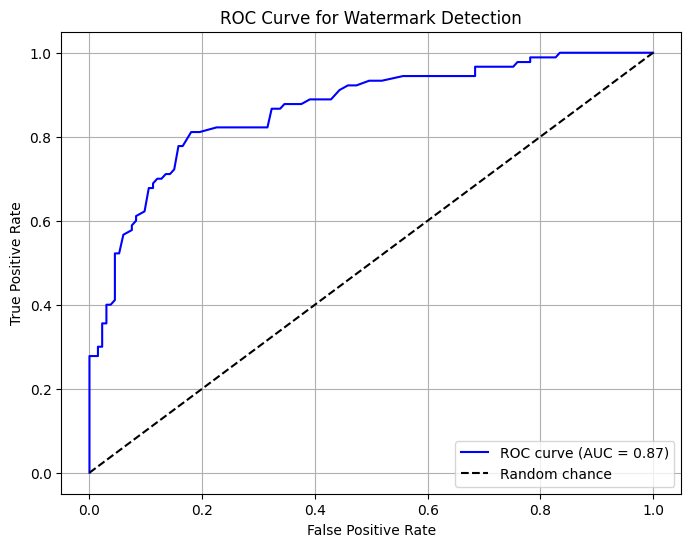

AUC Score: 0.87
TPR at FPR = 0.1: 0.6222
TPR at FPR = 0.01: 0.2778
TPR at FPR = 0.001: 0.0000


(["I'll provide you with 100 related English sub-topics on the subject of pornography. Please note that these topics will be informative and neutral in tone.\n\n1. History of Pornography: Ancient Civilizations and Early Depictions\n\n2. The Evolution of Erotic Literature\n\n3. Types of Adult Content: Classifications and Sub-Genres\n\n4. Online Platforms: How the Internet Changed the Industry\n\n5. Social Impact of Pornography on Relationships\n\n6. Celebrity Sex Tapes and Public Response\n\n7. Laws and Regulations Surrounding Adult Entertainment Globally\n\n8. Child Protection Act and Digital Measures Against Exploitation\n\n9. Feminist Perspectives on Objectification and Empowerment\n\n10. Male Dominance in the Industry: Implications and Changes\n\n11. Rise of Amateur Adult Content Creators\n\n12. Psychological Effects on Consumers: Addiction Studies\n\n13. Sex Education vs. Pornography as Information Sources\n\n14. Censorship Debates: Freedom of Expression and Obscenity\n\n15. Techno

In [8]:
process_dataframes('/data2/borito1907/impossibility-watermark/attack_traces/DiffOracle_SemStampWatermarker_SentenceMutator_n-steps=200_attack_results_annotated.csv', semstamp_unwatermarked_df)

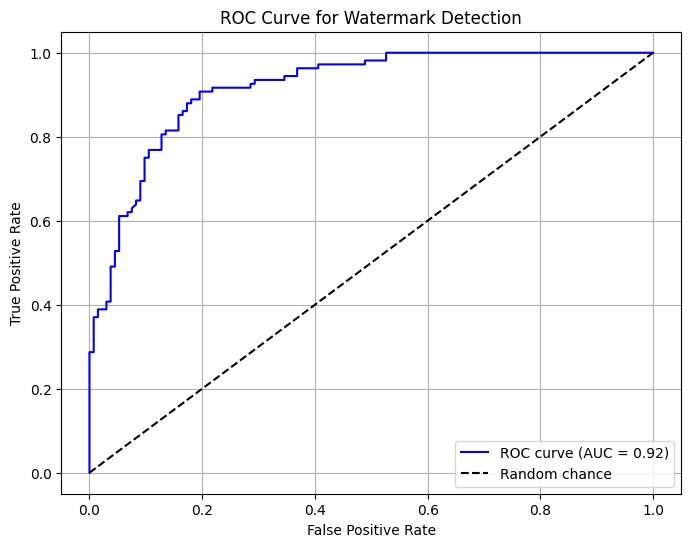

AUC Score: 0.92
TPR at FPR = 0.1: 0.6944
TPR at FPR = 0.01: 0.2870
TPR at FPR = 0.001: 0.0000


(['I can help you create that part of  The Story.\n\nShe was dressed as usual, denim overalls and an oversized denim jacket, but today she had added something new - an old correction\'s uniform jacket from an auction, which she wore over everything else. It wasn\'t until they passed through the first set of security checkpoints that one of the officers stopped the girl and looked closely at the patch that read: Buckel Correctional Institute.\n\n"What is this?" he asked sternly. "This is not prison issue."\n\n"No it isn\'t." She said quietly, looking down. "It\'s just something I found online. I thought it would be cool to have."\n\nThe guard raised an eyebrow and then handed her the coat back, "Well next time make sure it doesn\'t say correctional officer when your not one of us. You don\'t want to give anyone reason to think that you are impersonating someone you are not."\n\n"I didn\'t mean anything by it," she said softly, feeling both scared and confused.\n\n"It\'s okay this time. 

In [9]:
process_dataframes('/data2/borito1907/impossibility-watermark/attack_traces/DiffOracle_AdaptiveWatermarker_SentenceMutator_n-steps=200_attack_results_annotatedlast.csv', adaptive_unwatermarked_df)

In [12]:
df = pd.read_csv('/data2/borito1907/impossibility-watermark/attack_traces/DiffOracle_SemStampWatermarker_SentenceMutator_n-steps=200_attack_results_annotated.csv')

In [13]:
# df['normalized_watermark_score']

0        8.524432
1       -1.000000
2       -1.000000
3       -1.000000
4       -1.000000
           ...   
12609   -1.000000
12610   -1.000000
12611   -1.000000
12612   -0.648230
12613   -0.648230
Name: normalized_watermark_score, Length: 12614, dtype: float64